# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

***Описание данных***

Признаки

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

Целевой признак

    Price — цена (евро)

## Подготовка данных

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
# Откроем файл и запишем датасет в переменную data
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

In [3]:
# Посмотрим первые 10 строк датафрейма data
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
# Выведем общую информацию о датафрейме data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


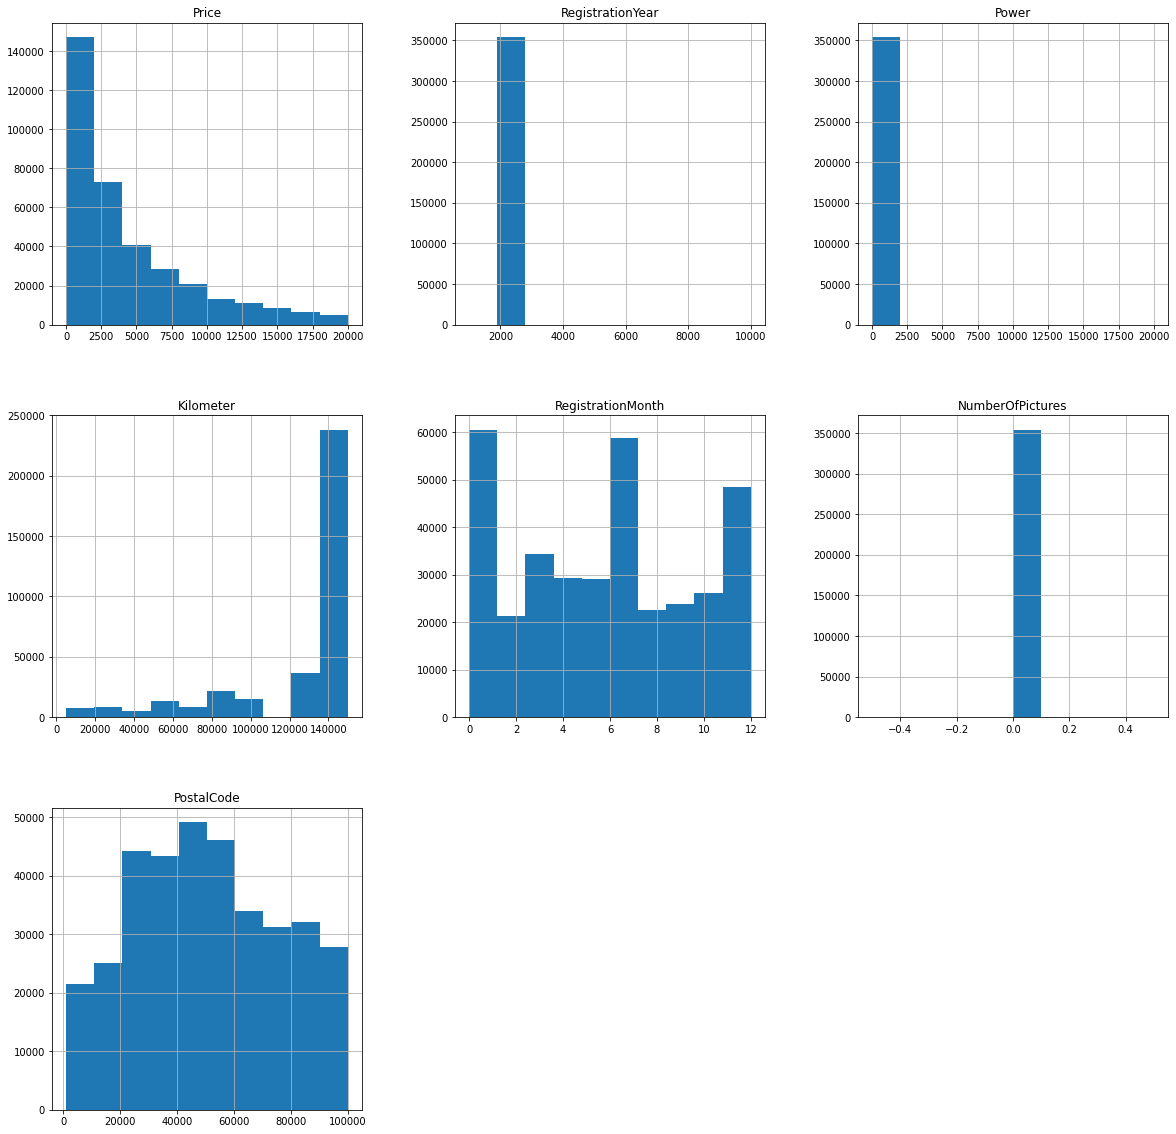

In [6]:
# Построим общую гистограмму для всех числовых столбцов таблицы
data.hist(figsize=(20, 20))
plt.show()

In [7]:
# Выведем количество пропущенных значений
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
print('Доля пропусков в vehicle_type: {:.2%}'.format(data['VehicleType'].isna().mean()))
print('Доля пропусков в gearbox: {:.2%}'.format(data['Gearbox'].isna().mean()))
print('Доля пропусков в model: {:.2%}'.format(data['Model'].isna().mean()))
print('Доля пропусков в fuel_type: {:.2%}'.format(data['FuelType'].isna().mean()))
print('Доля пропусков в not_repaired: {:.2%}'.format(data['Repaired'].isna().mean()))

Доля пропусков в vehicle_type: 10.58%
Доля пропусков в gearbox: 5.60%
Доля пропусков в model: 5.56%
Доля пропусков в fuel_type: 9.28%
Доля пропусков в not_repaired: 20.08%


In [9]:
# Переименуем столбцы
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]

# Проверим результат
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [10]:
# Заполним пропуски значением other
data.fuel_type.fillna('other', inplace=True)
data.vehicle_type.fillna('other', inplace=True)

In [11]:
# Заполним пропуски значением unknown
data.gearbox.fillna('unknown', inplace=True)
data.model.fillna('unknown', inplace=True)
data.repaired.fillna('unknown', inplace=True)

In [12]:
# Удалим ненужные столбцы
data = data.drop(['date_crawled','date_created', 'number_of_pictures','postal_code', 'last_seen'], axis=1)

In [13]:
# Проверим количество пропущенных значений
data.isnull().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
dtype: int64

In [14]:
# Посмотрим на значения в столбце registration_year
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [15]:
# Удалим аномалии
data = data.loc[(data['registration_year'] <= 2023) & (data['registration_year'] >= 1900)]

# Проверим результат
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1960, 1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956,
       1941, 1962, 1929, 1957, 1940, 1949, 2019, 1937, 1951, 1953, 1933,
       1950, 1948, 1952, 1932, 1942, 1935, 1936, 1923, 1930, 1944, 1943,
       1934, 1938, 1928, 1919, 1931, 1915, 1920, 1947, 1927, 1946])

In [16]:
# Посмотрим на значения в столбце power
data.power.value_counts()

0       40098
75      24020
60      15897
150     14590
101     13298
        ...  
9013        1
4400        1
1689        1
1433        1
6006        1
Name: power, Length: 711, dtype: int64

In [17]:
# Удалим аномалии
data = data.loc[data['power'] <= 700]

# Заполним нулевые значения межианой
data['power'] = data['power'].replace(0, data['power'].median())

In [18]:
# Посмотрим на значения в столбце price
data.price.value_counts()

0        10720
500       5655
1500      5379
1000      4640
1200      4589
         ...  
5240         1
13180        1
10879        1
2683         1
8188         1
Name: price, Length: 3730, dtype: int64

In [19]:
# Удалим аномалии
data = data.loc[data['price'] > 0]

# Проверим результат
data.price.value_counts()

500      5655
1500     5379
1000     4640
1200     4589
2500     4429
         ... 
7545        1
5240        1
13180       1
10879       1
8188        1
Name: price, Length: 3729, dtype: int64

In [20]:
# Проверим наличие явных дубликатов
data.duplicated().sum()

26188

In [21]:
# Удалим дубликаты
data.drop_duplicates(inplace=True)

In [22]:
# Выделим признаки
target_ohe = data['price']
features_ohe = data.drop('price', axis=1)

In [23]:
# Разделим датафрейм на обучающую, валидационную и тестовую выборку
features_train_ohe, features_x, target_train_ohe, target_y = train_test_split(features_ohe, target_ohe, test_size=0.4, random_state=12345)
features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(features_x, target_y, test_size=0.5, random_state=12345)

# Проверим соотношение выборок
print(features_train_ohe.shape)
print(features_valid_ohe.shape)
print(features_test_ohe.shape)

(190168, 10)
(63389, 10)
(63390, 10)


In [24]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(features_train_ohe)
features_train_ohe = encoder.transform(features_train_ohe)
features_valid_ohe = encoder.transform(features_valid_ohe)
features_test_ohe = encoder.transform(features_test_ohe)

In [25]:
# Выделим признаки
target_oe = data['price']
features_oe = data.drop('price', axis=1)

In [26]:
# Разделим датафрейм на обучающую, валидационную и тестовую выборку
features_train_oe, features_x, target_train_oe, target_y = train_test_split(features_oe, target_oe, test_size=0.4, random_state=12345)
features_valid_oe, features_test_oe, target_valid_oe, target_test_oe = train_test_split(features_x, target_y, test_size=0.5, random_state=12345)

# Проверим соотношение выборок
print(features_train_oe.shape)
print(features_valid_oe.shape)
print(features_test_oe.shape)

(190168, 10)
(63389, 10)
(63390, 10)


In [27]:
encoder = OrdinalEncoder(handle_unknown='ignore')
encoder.fit(features_train_oe)
features_train_oe = encoder.transform(features_train_oe)
features_valid_oe = encoder.transform(features_valid_oe)
features_test_oe = encoder.transform(features_test_oe)

In [28]:
# Отмасштабируем
scaler = StandardScaler()
scaler.fit(features_train_oe)
features_train_oe = pd.DataFrame(scaler.transform(features_train_oe))
features_valid_oe = pd.DataFrame(scaler.transform(features_valid_oe))
features_test_oe = pd.DataFrame(scaler.transform(features_test_oe))

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316947 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               316947 non-null  int64  
 1   vehicle_type        316947 non-null  object 
 2   registration_year   316947 non-null  int64  
 3   gearbox             316947 non-null  object 
 4   power               316947 non-null  float64
 5   model               316947 non-null  object 
 6   kilometer           316947 non-null  int64  
 7   registration_month  316947 non-null  int64  
 8   fuel_type           316947 non-null  object 
 9   brand               316947 non-null  object 
 10  repaired            316947 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 29.0+ MB


***Вывод:***

Датасет содержит 316947 записей. Удалены некорректные записи, недостающая информация восстановлена по существующим данным из других параметров. Выделены признаки, датасет разделен на обучающую и тестовую выборки. Произведено кодирование методами OrdinalEncoding и OneHotEncoding.

## Обучение моделей

In [30]:
%%time
# Линейная регрессия
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)
predictions_valid_ohe = model.predict(features_valid_ohe)
rmse_lr = mean_squared_error(target_valid_ohe, predictions_valid_ohe)**0.5
print(rmse_lr)

2073.7530890859935
CPU times: user 11.9 s, sys: 22.2 s, total: 34.2 s
Wall time: 34.2 s


In [31]:
%%time
# Дерево решений
for depth in range(3, 20, 3):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    model.fit(features_train_oe, target_train_oe)
    predictions_valid_oe = model.predict(features_valid_oe)
    rmse_dt = mean_squared_error(target_valid_oe, predictions_valid_oe)**0.5
    print('Глубина:', depth)
    print('RMSE для дерева решений:', rmse_dt)
    print('')
print()

Глубина: 3
RMSE для дерева решений: 2989.629505294177

Глубина: 6
RMSE для дерева решений: 2363.8832353503817

Глубина: 9
RMSE для дерева решений: 2121.6857051550287

Глубина: 12
RMSE для дерева решений: 2043.429183092272

Глубина: 15
RMSE для дерева решений: 2071.49996751155

Глубина: 18
RMSE для дерева решений: 2180.437518221491


CPU times: user 2.72 s, sys: 101 ms, total: 2.82 s
Wall time: 2.84 s


In [32]:
%%time
# Случайный лес
for est in [100, 500, 1000]:
    model = RandomForestRegressor(random_state=12345, 
                                   n_estimators=est, 
                                   max_depth=9)
    model.fit(features_train_oe, target_train_oe)
    predictions_valid_oe = model.predict(features_valid_oe)
    rmse_rf = mean_squared_error(target_valid_oe, predictions_valid_oe)**0.5
    print('Количество деревьев:', est)
    print('RMSE для случайного леса:', rmse_rf)
    print('')
print()

Количество деревьев: 100
RMSE для случайного леса: 2030.0632456946557

Количество деревьев: 500
RMSE для случайного леса: 2030.2292778532887

Количество деревьев: 1000
RMSE для случайного леса: 2030.4722110859195


CPU times: user 7min 30s, sys: 1.84 s, total: 7min 32s
Wall time: 7min 32s


In [36]:
%%time
# LightGBM
model = LGBMRegressor(random_state=12345)
model.fit(features_train_oe, target_train_oe)
predictions_valid_oe = model.predict(features_valid_oe)
rmse_lg = mean_squared_error(target_valid_oe, predictions_valid_oe)**0.5
print('RMSE для LightGBM:', rmse_lg)

RMSE для LightGBM: 1791.4587760566008
CPU times: user 5min 57s, sys: 2.81 s, total: 6min
Wall time: 6min 3s


***Вывод:***

Обучены модели: линейная регрессия, дерево решений, случайный лес, LightGBM. Сделаны предсказания, рассчитаны значения RMSE.

## Анализ моделей

In [37]:
results = {
    'Model' : ['LinearRegression','DecisionTreeRegressor', 'RandomForestRegressor', 'LGBMRegressor'],
    'RMSE' :pd.Series([2073, 2043, 2030, 1791]),
    'Время предсказания, sec': pd.Series(['34.2 s', '2.84 s', '7min 32s', '6min 3s']),
    }

display(pd.DataFrame(results))

,Model,RMSE,"Время предсказания, sec"
0,LinearRegression,2073,34.2 s
1,DecisionTreeRegressor,2043,2.84 s
2,RandomForestRegressor,2030,7min 32s
3,LGBMRegressor,1791,6min 3s


In [35]:
%%time
# Проверим LightGBM на тестовой выборке
model = LGBMRegressor(random_state=12345)
model.fit(features_train_oe, target_train_oe)
predictions_test_oe = model.predict(features_test_oe)
rmse_lg = mean_squared_error(target_test_oe, predictions_test_oe)**0.5
print('RMSE для LightGBM:', rmse_lg)

RMSE для LightGBM: 1759.4311759800046
CPU times: user 6min 12s, sys: 2.81 s, total: 6min 15s
Wall time: 6min 18s


***Вывод:***

Датасет содержит 303924 записей. Удалены некорректные записи, недостающая информация восстановлена по существующим данным из других параметров. Выделены признаки, датасет разделен на обучающую и тестовую выборки. Произведено кодирование методами OrdinalEncoding и OneHotEncoding.

Обучены модели: линейная регрессия, дерево решений, случайный лес, LightGBM. Сделаны предсказания, рассчитаны значения RMSE.

Наилучшая модель - LightGBM:
 * Время работы - 6min 3s
 * RMSE - 1791

RMSE для LightGBM на тестовой выборке: 1759